*First compiled on: December, 3 2016.*

# Simulating myeloid progenitors

In [1]:
%config InlineBackend.figure_formats = ['png2x']  # for vector graphics quality, set to svg
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3                # control level of output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.5 on 2017-08-01 00:40.


Here, we are going to simulate some data using a literature-curated boolean gene
regulatory network, which is believed to describe myeloid differentiation
([Krumsiek *et al.*, 2011](#ref_krumsiek11)). Using [sim](https://github.com/theislab/scanpy/tree/master/scanpy/tools/sim.py), the
[boolean model](https://github.com/theislab/scanpy/tree/master/scanpy/sim_models/krumsiek11.txt)
```
Gata2 = Gata2 and not (Gata1 and Fog1) and not Pu.1
Gata1 = (Gata1 or Gata2 or Fli1) and not Pu.1
Fog1 = Gata1
EKLF = Gata1 and not Fli1
Fli1 = Gata1 and not EKLF
SCL = Gata1 and not Pu.1
Cebpa = Cebpa and not (Gata1 and Fog1 and SCL)
Pu.1 = (Cebpa or Pu.1) and not (Gata1 or Gata2)
cJun = Pu.1 and not Gfi1
EgrNab = (Pu.1 and cJun) and not Gfi1
Gfi1 = Cebpa and not EgrNab
```
is translated into a stochastic differential equation ([Wittmann *et al.*, 2009](#ref_wittmann09)). Simulations result
in branching time series of gene expression, where each branch corresponds to a
certain cell fate of common myeloid progenitors (megakaryocytes, erythrocytes,
granulocytes and monocytes).

Instead of simulating the data as in the next line, you can also retrieve it from the builtin examples
```
adata = sc.examples.krumsiek11()
```

In [2]:
adata = sc.tl.sim('krumsiek11')

reading params file /Users/alexwolf/hholtz/01_projects/1512_scanpy/scanpy/scanpy/sim_models/krumsiek11_params.txt
setting `settings.run_name = krumsiek11`
writing to directory ./write/krumsiek11_sim
reading file ./write/krumsiek11_sim/sim_000000.txt
    assuming last comment line stores variable names
    assuming first column in file stores row names
    read data into list of lists (0:00:30.352)
    constructed array from list of list (0:00:00.000)


In [3]:
sc.write('krumsiek11', adata)

writing ./write/krumsiek11.h5


Plot the four realizations of time series.

reading file ./write/krumsiek11.h5


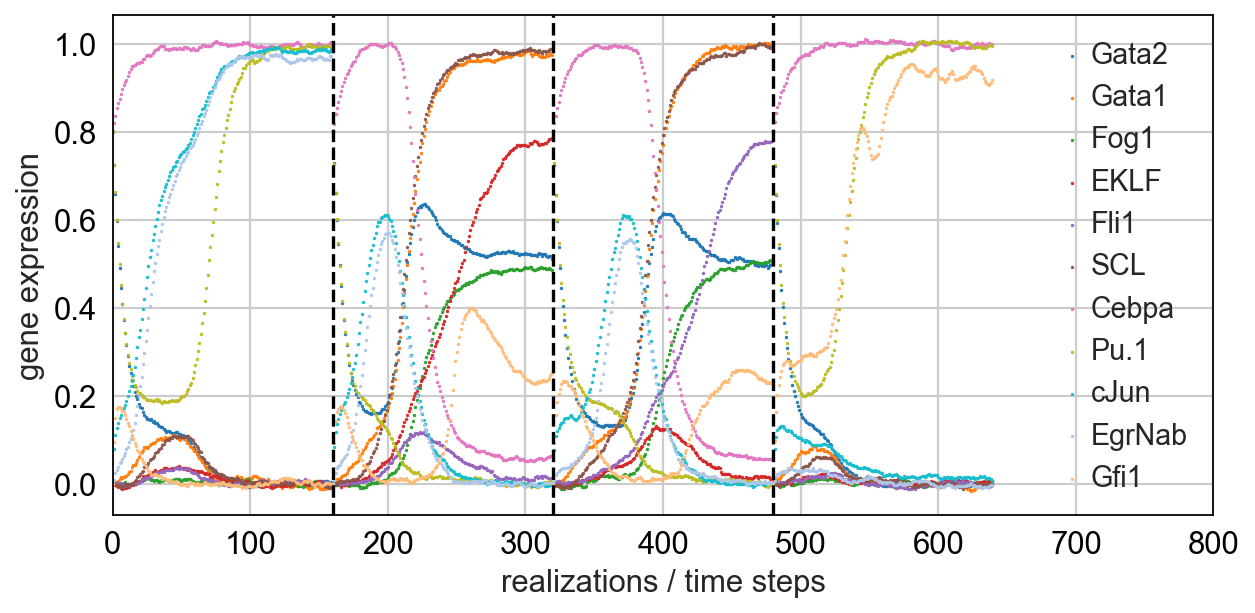

In [2]:
adata = sc.read('krumsiek11')
sc.pl.sim(adata)

Compute further visualizations.

In [3]:
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)
sc.write('krumsiek11', adata)

computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:01.295) and added
    "X_tsne", tSNE coordinates (adata.smp)
drawing single-cell graph using layout "fr"
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    using data matrix X directly for building graph (no PCA)
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9984189272  0.9969583154  0.9920811653  0.9909049273
      0.9824624062  0.9651805758  0.9614249468  0.9520583749  0.9385528564
      0.9172899723  0.9089727402  0.8958978653  0.8761962652  0.8536654115]
    finished (0:00:03.539) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_layout", the chosen layout (adata.add)
writing ./write/krumsiek11.h5


Inspecting the genes of the fixed poitns, we can make the following annotation.

In [4]:
adata = sc.read('krumsiek11')
fate_labels = {0: 'progenitor', 159: 'monocyte', 319: 'erythrocyte', 
               459: 'megacaryocyte', 619: 'neutrophil'}
adata.add['highlights'] = fate_labels

reading file ./write/krumsiek11.h5


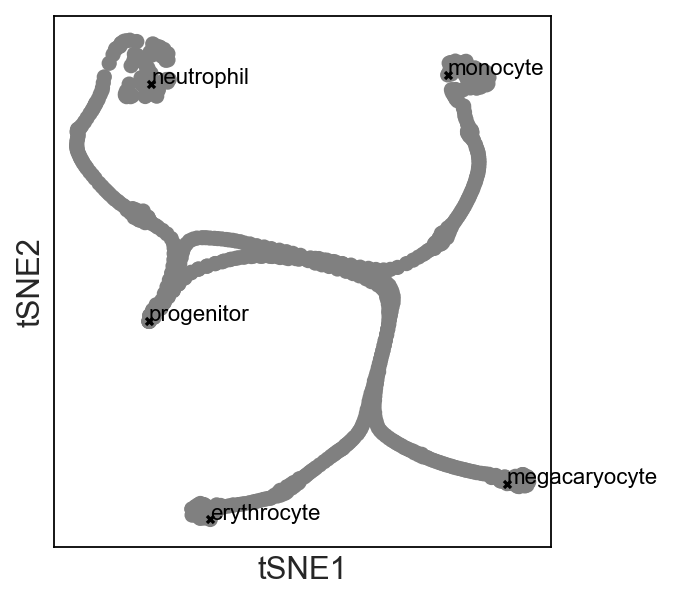

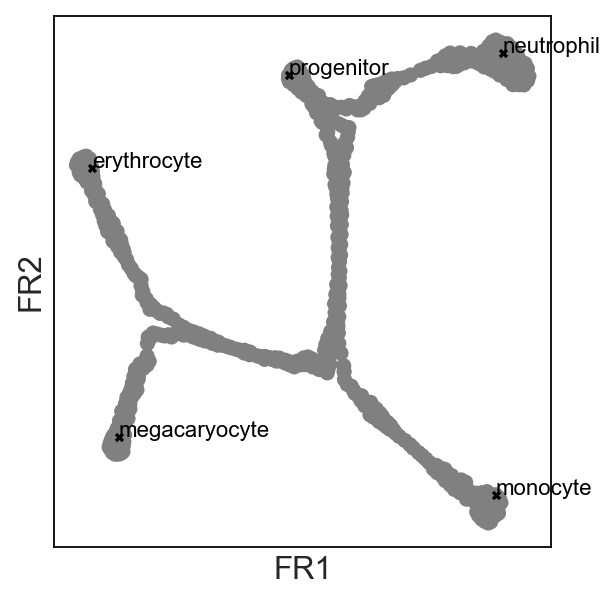

In [5]:
ax = sc.pl.tsne(adata)
asx = sc.pl.draw_graph(adata)

### Reconstructing progression and branching using DPT

In [6]:
adata.add['iroot'] = 0
sc.tl.dpt(adata, n_branchings=2, n_neighbors=5, knn=False)

perform Diffusion Pseudotime analysis
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 5 
    using data matrix X directly for building graph (no PCA)
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9999370575  0.9999125004  0.9998248816  0.9997677207
      0.9993129373  0.9989748001  0.9986641407  0.9982346892  0.9980639219]
    this uses a hierarchical implementation
    detect 2 branchings
    do not consider groups with less than 6 points for splitting
    branching 1: split group 0
    branching 2: split group 0
finished (0:00:00.478) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


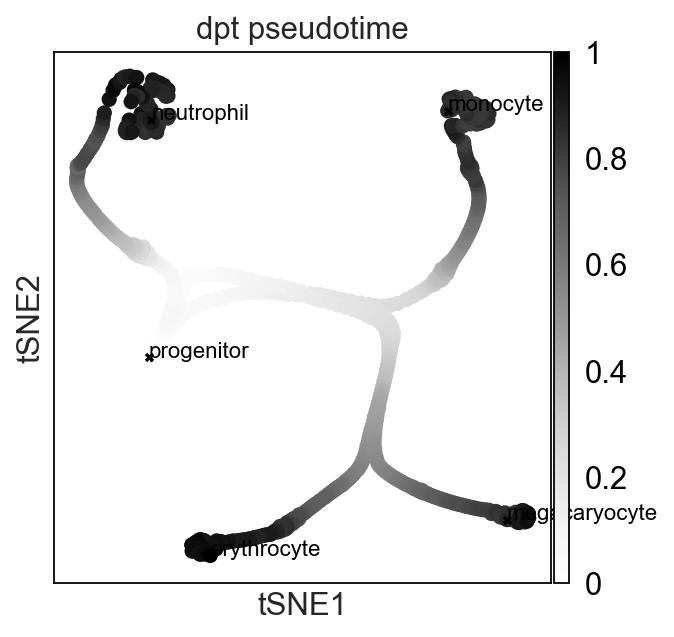

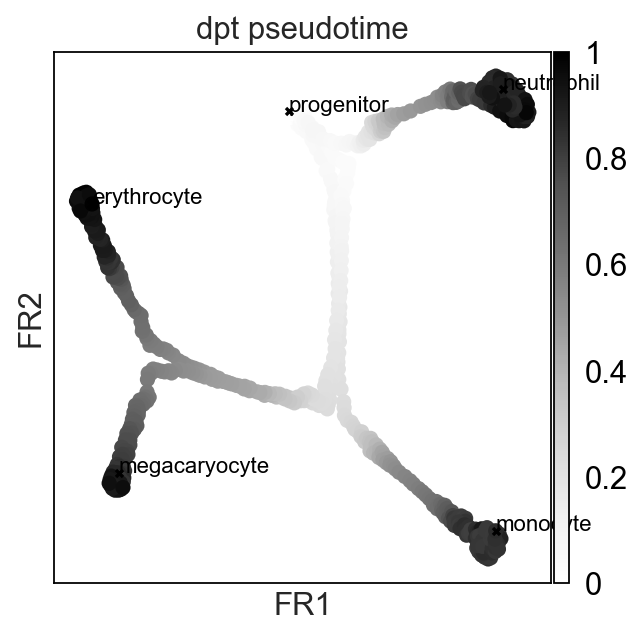

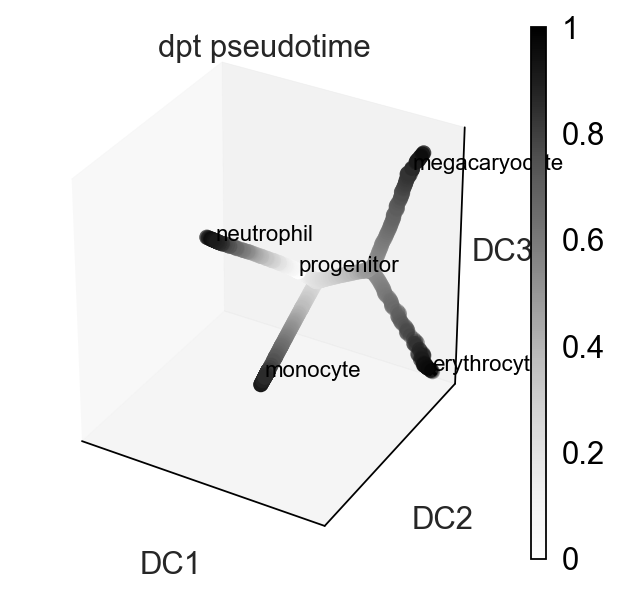

In [7]:
ax = sc.pl.tsne(adata, color='dpt_pseudotime')
ax = sc.pl.draw_graph(adata, color='dpt_pseudotime')
ax = sc.pl.diffmap(adata, color='dpt_pseudotime', projection='3d')

In the diffusion maps visualization, the "cuts" into branches are at meaningful positions. In tSNE and FR, they appear quite arbitrary.

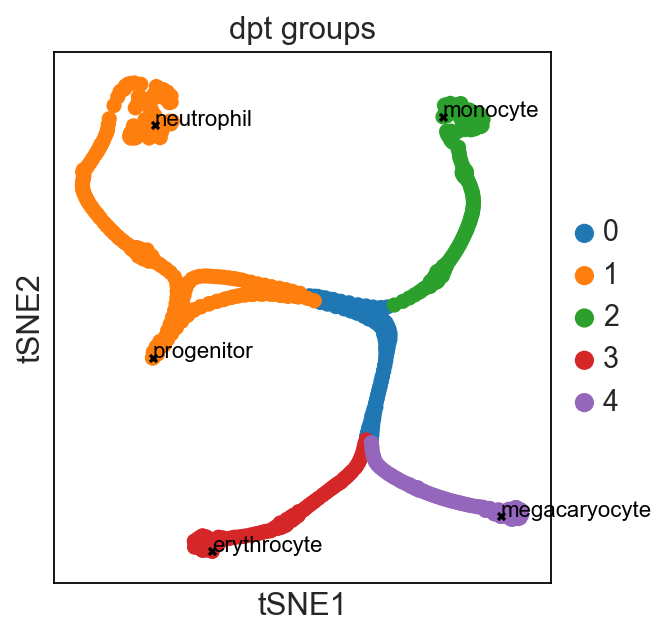

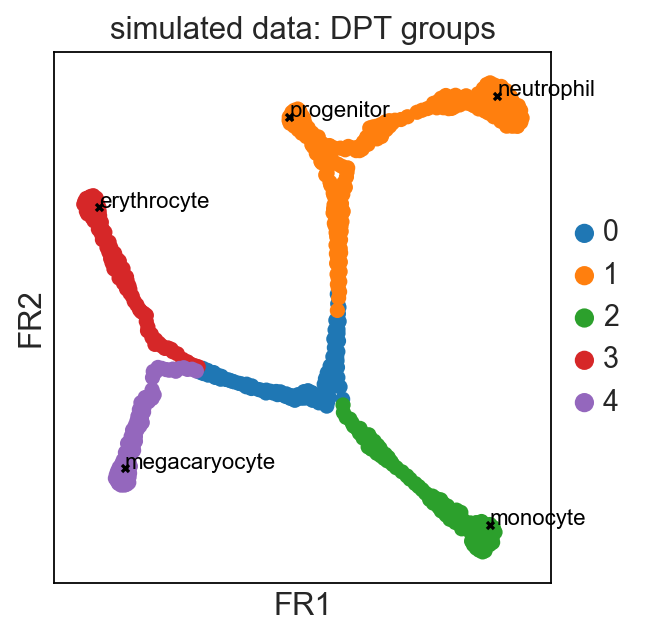

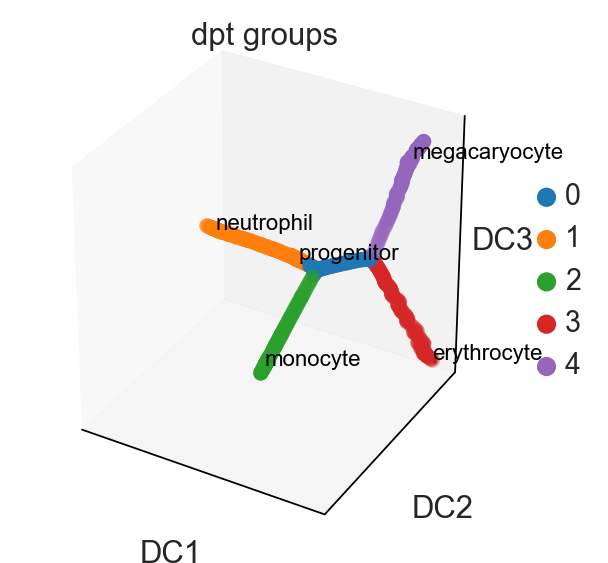

In [8]:
ax = sc.pl.tsne(adata, color='dpt_groups')
ax = sc.pl.draw_graph(adata, color='dpt_groups', title='simulated data: DPT groups')
ax = sc.pl.diffmap(adata, color='dpt_groups', projection='3d')